In [1]:
import os
import sys
import numpy as np
from importlib import reload  
import support as sup
reload(sup)
sys.path.insert(0, '../icenumerics')

import icenumerics as ice

from icenumerics.geometry import ordering 
import magcolloids as mgc

import matplotlib.pyplot as plt
ureg = ice.ureg

%load_ext autoreload
%autoreload 2

# Simulation videos

    In this script, we will run a simulation and obtain a set of frames that we will use to build a video of the evolution of the particle positions and vertices. 

In [2]:
output = "/home/carolina/CairoLattice_ACI_PROJECT/Scripts/Output_Script-7.0"

In [3]:
np.random.seed()

l = 7

sp = sup.spins()
ureg = ice.ureg
sp.create_lattice(geometry = "cairo",size =[l,l],lattice_constant=19.5458*ureg.um, border="fixed conf")
sp.order_spins(ordering.random_ordering) # Add this line to start from a random ordering

/home/carolina/CairoLattice_ACI_PROJECT/Scripts/support.py:111: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new[:,0] = centers_toAddX
/home/carolina/CairoLattice_ACI_PROJECT/Scripts/support.py:112: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new[:,1] = centers_toAddY
/home/carolina/CairoLattice_ACI_PROJECT/Scripts/support.py:212: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new_centers[:,1] = centersY


In [4]:
particle = ice.particle(radius = 5*ureg.um,
             susceptibility = 0.005,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap_long = ice.trap(trap_sep = 10*ureg.um,
               height = 25*ureg.pN*ureg.nm,
               stiffness = 0.1*ureg.fN/ureg.nm)

trap_short = ice.trap(trap_sep = 4.5258*ureg.um,
               height = 25*ureg.pN*ureg.nm,
               stiffness = 0.1*ureg.fN/ureg.nm)

traps = []

In [5]:
for s in sp:
    
    if ( s.direction[0].magnitude == 1.0 or s.direction[0].magnitude == -1.0 or 
        s.direction[1].magnitude == 1.0 or s.direction[1].magnitude == -1.0 ):
        
        traps.append(trap_short)
        
    else:
        
        traps.append(trap_long)

In [6]:
col = ice.colloidal_ice(sp, particle, traps, height_spread = 0, susceptibility_spread = 0.1)

col.pad_region(40*ureg.um) 

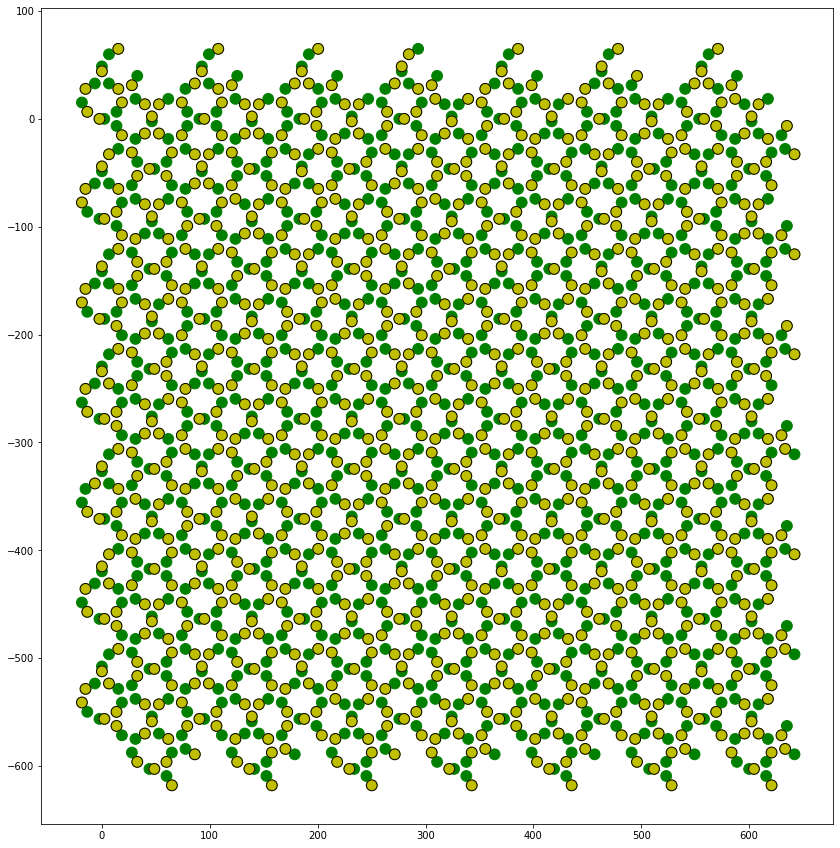

In [7]:
f, (ax1) = plt.subplots(1,1,figsize = (15,15))
col.display(ax1)

In [8]:
world = ice.world(
    field = 25*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)

In [9]:
%%time
change_m_time = 2000*ureg.s
total_time = 2500*ureg.s
col.simulate(world,
             name = "ACI_CairoLattice_l%u_25mT-2000s_ramp+cte"%(l),
             include_timestamp = False,
             targetdir = output,
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = total_time,
             output = ["x","y","z","mux","muy","muz"])

scanning file


CPU times: user 37.5 s, sys: 439 ms, total: 38 s
Wall time: 16min 21s


In [10]:
change_m_time = 2000*ureg.s
change_m_time.to(ureg.us)

2000000000.0 <Unit('microsecond')>

In [ ]:
%%time
col.sim.field.fieldz = "(time<2000000000)*v_Bmag*time/%f+(time>=2000000000)*v_Bmag"%(change_m_time.to(ureg.us).magnitude)
col.run_simulation()

In [ ]:
col.load_simulation(slice(0,None,1))

In [ ]:
def field_func(frame):
    
    """ Returns the value of the magnetic field at a certain frame when we fist apply a magnetic field ramp
    and then we keep constant the magnetic field value."""
    
    # The maximum magnetic field value reached in the simulation.
    fieldMax = 25
    
    # frameChange is the value in time where the dependece of the field with time changes. 
    frameChange = 2000
    
    if frame < frameChange:
        field = frame*fieldMax/frameChange
        
    else:
        
        field = fieldMax
        
    return field

In [ ]:
col.trj

In [ ]:
i = 2500
field = field_func(i)
field

In [ ]:
f, (ax1) = plt.subplots(1,1,figsize = (15,15))
field = []
v = ice.vertices()
col.set_state_from_frame(i)
v = v.colloids_to_vertices(col)

col.display(ax1)
v.display(ax1)

ax1.set_xticks([])
ax1.set_yticks([])
field = field_func(i)
plt.text(570, 55, str(round(field,1)) , fontsize=50)

#plt.savefig(os.path.join(output,"Ramp+cte_frame"+str(i)+".png"))
#plt.close()

In [ ]:

for i in range(0,2500,5):
    field = []
    f, (ax1) = plt.subplots(1,1,figsize = (15,15))
    v = ice.vertices()
    col.set_state_from_frame(i)
    v = v.colloids_to_vertices(col)

    col.display(ax1)
    v.display(ax1)

    ax1.set_xticks([])
    ax1.set_yticks([])
    field = field_func(i)
    plt.text(520, 55, str(round(field,1))+' mT' , fontsize=50)
    plt.text(510, -650, str(i)+' s' , fontsize=50)
    plt.savefig(os.path.join(output,"Ramp+cte_frame"+str(i)+".png"))
    plt.close()